In [1]:
!pip install pyvista
!pip install matplotlib
!pip install pygmsh

In [ ]:
# MUST RUN THIS CELL:
!pip uninstall -y h5py
!pip install h5py==2.9.0

In [1]:
import dolfinx
import numpy as np
from mpi4py import MPI
from dolfinx.cpp.mesh import CellType
import dolfinx.io
import pyvista
import dolfinx.plot
from math import sin, cos, pi
import pygmsh
import gmsh
import meshio
import ufl
from petsc4py import PETSc

In [2]:
W_1 = 40 # in mm
L_1 = 90 # in mm
W_2 = 5 # in mm
L_2 = 20 # in mm
E =  10 # in mPa
nu = 0.33 # dimensionless
rho = 0.00102 # in g mm^-3
g = 9.81 # in m s^-2
mu = E/(2*(1+nu))
lambda_ = E*nu/((1+nu)*(1-2*nu))

In [3]:
def create_mesh(W_1, W_2, L_1, L_2, mesh_size, num_layers):
    
    # Create meshio file:
    with pygmsh.geo.Geometry() as geom:
        poly = geom.add_polygon([[0.0, 0.0, 0.0],
                                 [0.0, 0.0, W_1],
                                 [L_2, 0.0, W_1],
                                 [L_1, 0.0, W_2],
                                 [L_1, 0.0, 0.0]], mesh_size=mesh_size)
        geom.extrude(poly, [0.0, W_1, 0.0], num_layers=num_layers)
        pygmsh_mesh = geom.generate_mesh(dim=3)
        pygmsh.write('beam_mesh.msh')
    
    # Also take note of number of elements in the mesh:
    num_elem = pygmsh_mesh.get_cells_type("tetra").shape[0]
    
    # Load mesh file:
    mesh3D_from_msh = meshio.read("beam_mesh.msh")
    cells = mesh3D_from_msh.get_cells_type("tetra")
    tetra_mesh = meshio.Mesh(points=mesh3D_from_msh.points, cells={"tetra": cells})
    
    # Convert to xdmf file then load:
    meshio.write("beam_mesh.xdmf", tetra_mesh)
    with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "beam_mesh.xdmf", 'r') as f:
        mesh = f.read_mesh(name="Grid")
    
    return (mesh, num_elem)

In [4]:
mesh_size = 5
num_layers = 5
mesh, num_elem = create_mesh(W_1, W_2, L_1, L_2, mesh_size, num_layers)
V = dolfinx.VectorFunctionSpace(mesh, ("CG", 2))

In [5]:
def left(x):
    return np.isclose(x[0], 0)

def right(x):
    return np.isclose(x[0], L_1)

left_facets = dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, left)
right_facets = dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, right)

In [6]:
# Concatenate and sort the arrays based on facet indices. Left facets marked with 1, right facets with two
marked_facets = np.hstack([left_facets, right_facets])
marked_values = np.hstack([np.full(len(left_facets), 1, dtype=np.int32), np.full(len(right_facets), 2, dtype=np.int32)])
sorted_facets = np.argsort(marked_facets)
facet_tag = dolfinx.MeshTags(mesh, mesh.topology.dim-1, marked_facets[sorted_facets], marked_values[sorted_facets])

In [7]:
u_bc = dolfinx.Function(V)
with u_bc.vector.localForm() as loc:
    loc.set(0)

In [8]:
left_dofs = dolfinx.fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.indices[facet_tag.values==1])
bcs = [dolfinx.DirichletBC(u_bc, left_dofs)]

In [9]:
B = dolfinx.Constant(mesh, (0, 0, 0))
T = dolfinx.Constant(mesh, (0, 0, 0))

In [10]:
v = ufl.TestFunction(V)
u = dolfinx.Function(V)

In [11]:
# Spatial dimension
d = len(u)

# Identity tensor
I = ufl.variable(ufl.Identity(d))

# Deformation gradient
F = ufl.variable(I + ufl.grad(u))

# Right Cauchy-Green tensor
C = ufl.variable(F.T * F)

# Invariants of deformation tensors
Ic = ufl.variable(ufl.tr(C))
J  = ufl.variable(ufl.det(F))

In [12]:
# Elasticity parameters
mu = dolfinx.Constant(mesh, E/(2*(1 + nu)))
lmbda = dolfinx.Constant(mesh, E*nu/((1 + nu)*(1 - 2*nu)))
# Stored strain energy density (compressible neo-Hookean model)
psi = (mu / 2) * (Ic - 3) - mu * ufl.ln(J) + (lmbda / 2) * (ufl.ln(J))**2
# Hyper-elasticity
P = ufl.diff(psi, F)

In [13]:
metadata = {"quadrature_degree": 4}
ds = ufl.Measure('ds', subdomain_data=facet_tag, metadata=metadata)
dx = ufl.Measure("dx", metadata=metadata)
# Define form F (we want to find u such that F(u) = 0)
F = ufl.inner(ufl.grad(v), P)*dx - ufl.inner(v, B)*dx - ufl.inner(v, T)*ds(2) 

In [14]:
problem = dolfinx.fem.NonlinearProblem(F, u, bcs)

In [15]:
solver = dolfinx.NewtonSolver(MPI.COMM_WORLD, problem)

# Set Newton solver options
solver.atol = 1e-3
solver.rtol = 1e-3
solver.convergence_criterion = "incremental"

  warnings.warn("Plotting of higher order functions is experimental.")


Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'



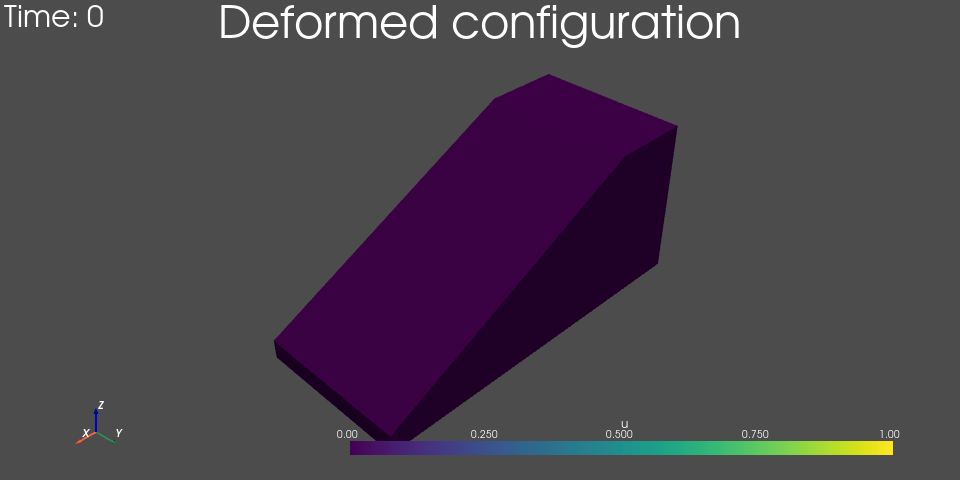

In [16]:
# Activate framebuffer, required for visualziation
pyvista.start_xvfb(wait=0.05)
# Create background plotter and mesh to attach values to
topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)
def plot_function(t, uh):
    p = pyvista.Plotter(window_size=[960,480])
    # Add time-stamp
    p.add_text(f"Time: {t}", font_size=12, name="timelabel")
    p.add_text("Deformed configuration", name="title", position="upper_edge")
   
    # Update point values on pyvista grid

    topology, cell_types = dolfinx.plot.create_vtk_topology(V)
     # We create a geometry for our modified mesh using the dof coordinates
    geometry = V.tabulate_dof_coordinates()
    # As we are dealing with a vector field, we reshape the underlying dof array to accommedate for the three dimensional space
    num_dofs = V.dofmap.index_map.size_local + V.dofmap.index_map.num_ghosts
    values = np.zeros((num_dofs, 3), dtype=np.float64)
    values[:, :mesh.geometry.dim] = uh.x.array.real.reshape(num_dofs, V.dofmap.index_map_bs)

    # Create grid defined by the function space for visualization
    function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
    function_grid["u"] = values
    function_grid.set_active_vectors("u")
    # Warp mesh by deformation
    warped = function_grid.warp_by_vector("u", factor=1)
    
    # Add mesh to plotter and visualize
    actor = p.add_mesh(warped)
    p.show_axes()
    if not pyvista.OFF_SCREEN:
       p.show()
    else:
        figure_as_array = p.screenshot(f"diffusion_{t:.2f}.png")
        # Clear plotter for next plot
        p.remove_actor(actor)

plot_function(0, u)

2021-10-24 03:19:56.920 ( 216.961s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:19:57.753 ( 217.794s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:19:58.347 ( 218.388s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 276.136 (tol = 0.001) r (rel) = 0.200675(tol = 0.001)
2021-10-24 03:19:58.612 ( 218.653s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:19:59.281 ( 219.322s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 77.2809 (tol = 0.001) r (rel) = 0.0561619(tol = 0.001)
2021-10-24 03:19:59.576 ( 219.618s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:00.213 ( 220.254s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 

Time step 0, Number of iterations 7, Load [ 0.  0. -0.]


2021-10-24 03:20:02.041 ( 222.082s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 6: r (abs) = 15.1639 (tol = 0.001) r (rel) = 0.0110199(tol = 0.001)
2021-10-24 03:20:02.301 ( 222.342s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:02.903 ( 222.944s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 7: r (abs) = 0.150909 (tol = 0.001) r (rel) = 0.000109669(tol = 0.001)
2021-10-24 03:20:02.903 ( 222.944s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 7 iterations and 7 linear solver iterations.


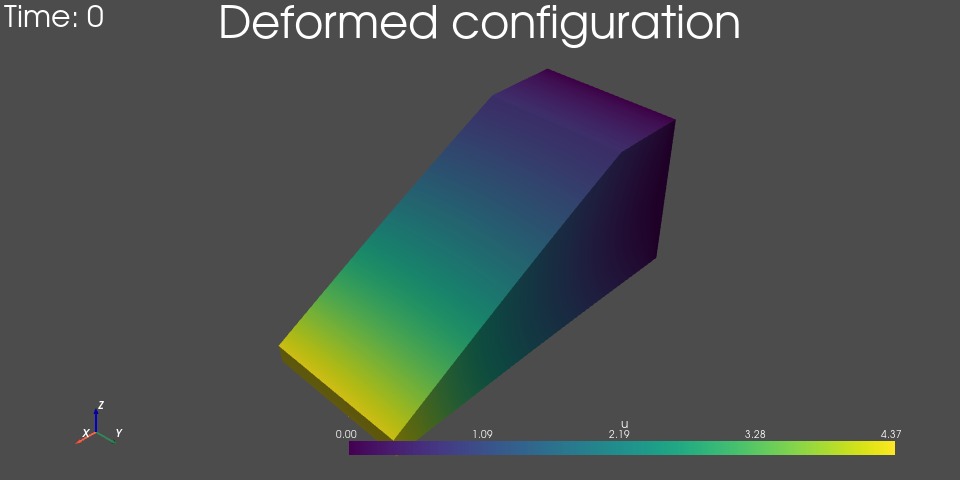

2021-10-24 03:20:03.710 ( 223.751s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:04.575 ( 224.616s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:05.212 ( 225.253s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.29183 (tol = 0.001) r (rel) = 0.0179588(tol = 0.001)


Time step 1, Number of iterations 3, Load [ 0.  0. -0.]


2021-10-24 03:20:05.485 ( 225.527s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:06.139 ( 226.180s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 0.0973477 (tol = 0.001) r (rel) = 0.000762817(tol = 0.001)
2021-10-24 03:20:06.139 ( 226.180s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 3 linear solver iterations.


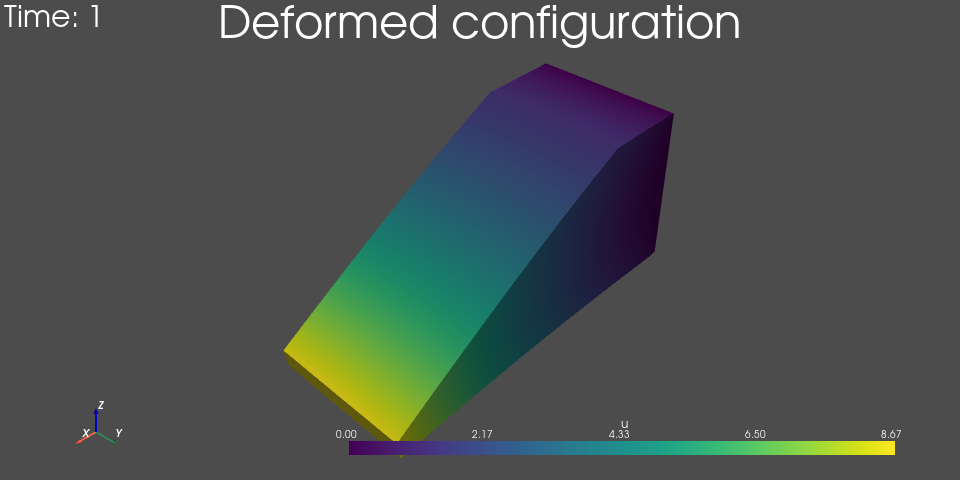

2021-10-24 03:20:06.938 ( 226.980s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:07.962 ( 228.003s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:08.634 ( 228.675s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.26102 (tol = 0.001) r (rel) = 0.0179825(tol = 0.001)
2021-10-24 03:20:08.943 ( 228.984s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:09.607 ( 229.649s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 0.111165 (tol = 0.001) r (rel) = 0.000884123(tol = 0.001)
2021-10-24 03:20:09.607 ( 229.649s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 3 linear solver iterations.


Time step 2, Number of iterations 3, Load [ 0.  0. -0.]


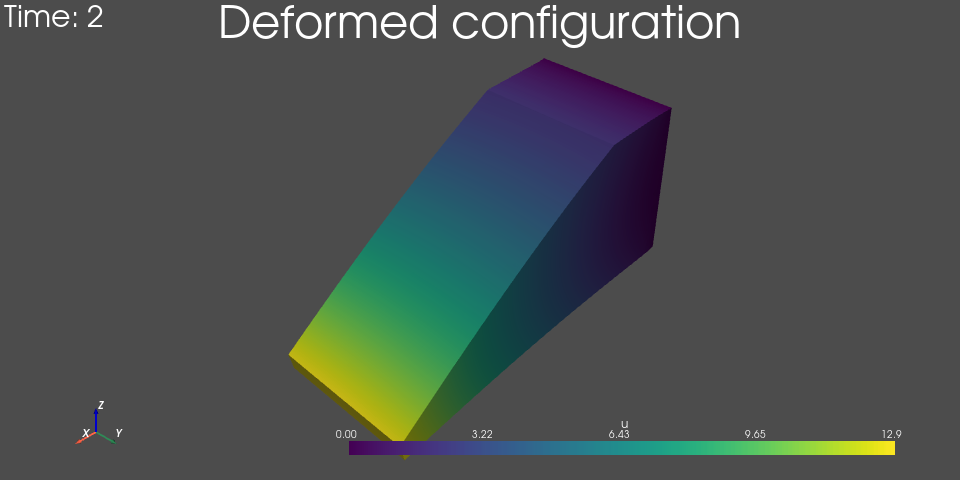

2021-10-24 03:20:10.429 ( 230.470s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:11.326 ( 231.367s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:11.951 ( 231.992s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.22376 (tol = 0.001) r (rel) = 0.0179932(tol = 0.001)
2021-10-24 03:20:12.222 ( 232.263s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:12.877 ( 232.918s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 0.11947 (tol = 0.001) r (rel) = 0.00096667(tol = 0.001)
2021-10-24 03:20:12.877 ( 232.918s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 3 linear solver iterations.


Time step 3, Number of iterations 3, Load [ 0.  0. -0.]


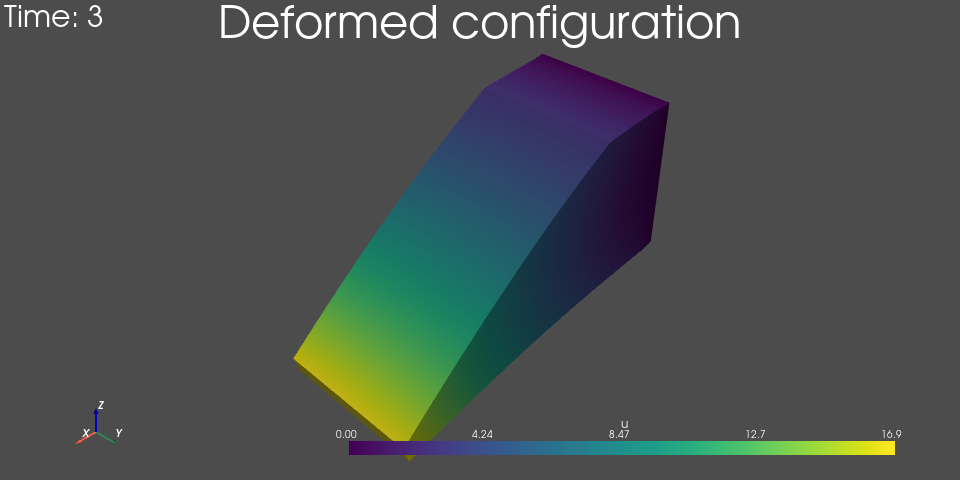

2021-10-24 03:20:13.693 ( 233.735s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:14.531 ( 234.572s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:15.128 ( 235.170s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.18037 (tol = 0.001) r (rel) = 0.0179868(tol = 0.001)
2021-10-24 03:20:15.393 ( 235.434s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:16.011 ( 236.052s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 0.122718 (tol = 0.001) r (rel) = 0.00101236(tol = 0.001)
2021-10-24 03:20:16.280 ( 236.321s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:16.897 ( 236.938s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iterati

Time step 4, Number of iterations 4, Load [ 0.    0.   -0.01]


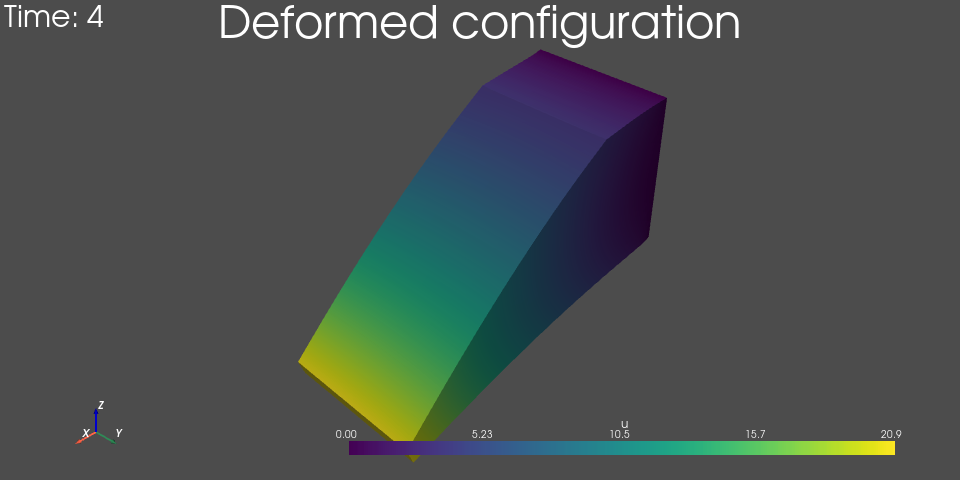

2021-10-24 03:20:17.761 ( 237.802s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:18.704 ( 238.746s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:19.360 ( 239.401s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.13139 (tol = 0.001) r (rel) = 0.0179602(tol = 0.001)
2021-10-24 03:20:19.623 ( 239.665s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:20.218 ( 240.259s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 0.121602 (tol = 0.001) r (rel) = 0.00102468(tol = 0.001)
2021-10-24 03:20:20.463 ( 240.504s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:21.067 ( 241.108s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iterati

Time step 5, Number of iterations 4, Load [ 0.    0.   -0.01]


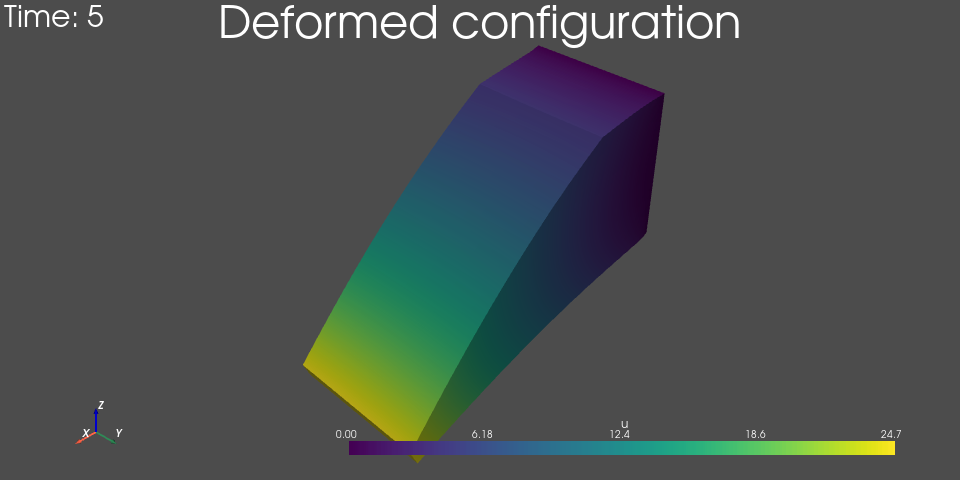

2021-10-24 03:20:21.924 ( 241.966s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:22.951 ( 242.992s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:23.608 ( 243.649s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.07739 (tol = 0.001) r (rel) = 0.01791(tol = 0.001)
2021-10-24 03:20:23.870 ( 243.912s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:24.425 ( 244.466s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 0.116988 (tol = 0.001) r (rel) = 0.0010086(tol = 0.001)
2021-10-24 03:20:24.649 ( 244.690s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:25.236 ( 245.278s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 

Time step 6, Number of iterations 4, Load [ 0.    0.   -0.01]


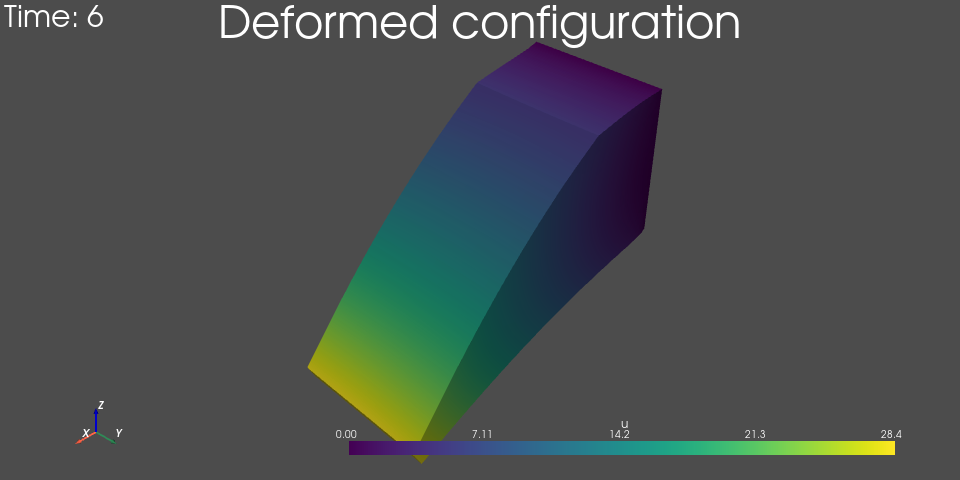

2021-10-24 03:20:25.953 ( 245.995s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:26.663 ( 246.705s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:27.242 ( 247.284s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.01908 (tol = 0.001) r (rel) = 0.0178342(tol = 0.001)


Time step 7, Number of iterations 3, Load [ 0.    0.   -0.01]


2021-10-24 03:20:27.494 ( 247.535s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:28.117 ( 248.158s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 0.109827 (tol = 0.001) r (rel) = 0.000970083(tol = 0.001)
2021-10-24 03:20:28.117 ( 248.158s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 3 linear solver iterations.


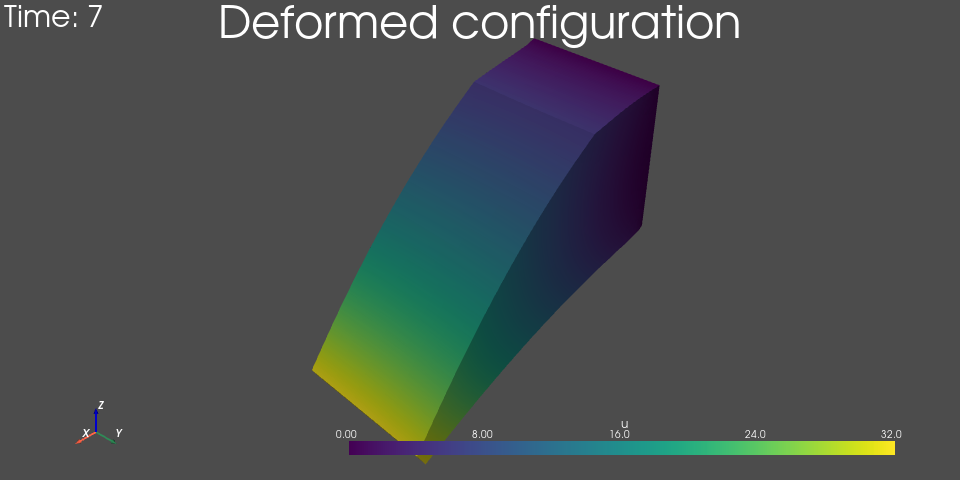

2021-10-24 03:20:28.808 ( 248.849s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:29.679 ( 249.720s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:30.294 ( 250.335s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.95719 (tol = 0.001) r (rel) = 0.0177314(tol = 0.001)
2021-10-24 03:20:30.560 ( 250.602s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:31.142 ( 251.183s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 0.101012 (tol = 0.001) r (rel) = 0.00091513(tol = 0.001)
2021-10-24 03:20:31.142 ( 251.183s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 3 linear solver iterations.


Time step 8, Number of iterations 3, Load [ 0.    0.   -0.01]


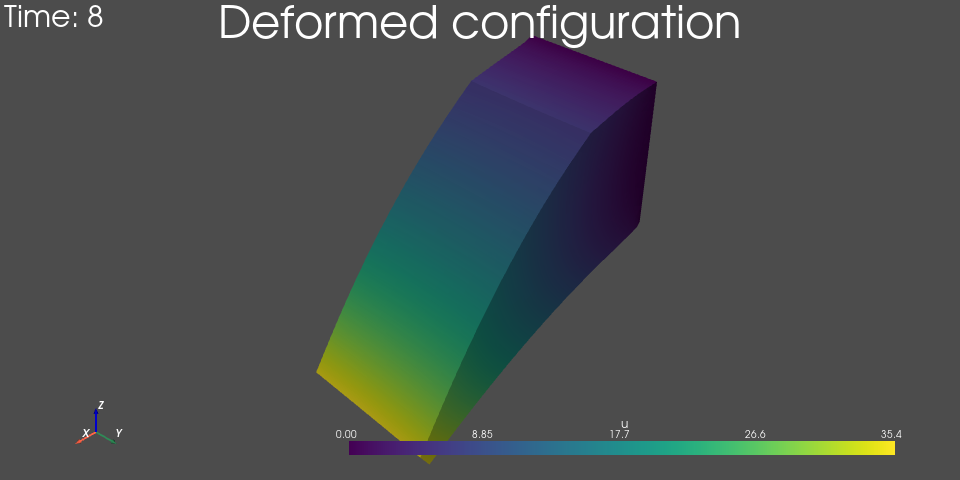

2021-10-24 03:20:31.890 ( 251.931s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-10-24 03:20:32.636 ( 252.677s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.


In [ ]:
beam_angle = 90
beam_angle *= pi/180
num_steps = 10
f_step = rho*g/num_steps
dolfinx.log.set_log_level(dolfinx.log.LogLevel.INFO)
for n in range(num_steps):
    B.value[0] = (n+1)*f_step*cos(beam_angle)
    B.value[2] = -(n+1)*f_step*sin(beam_angle)
    num_its, converged = solver.solve(u)
    assert(converged)
    u.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    print(f"Time step {n}, Number of iterations {num_its}, Load {B.value}")
    plot_function(n, u)